In [44]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.applications import InceptionResNetV2, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, jaccard_score


# Data Loading and Analysis

## Random Image Loading and Displaying Function

This set of functions is designed to load a specified number of random images from a given directory and display them using matplotlib.

### `load_random_images(directory, num_images=5)`
- **Parameters:**
  - `directory`: The directory path containing the images.
  - `num_images`: Number of random images to load (default is 5).
- **Returns:**
  - A list of randomly selected images loaded from the specified directory.

### `display_images(images, titles)`
- **Parameters:**
  - `images`: List of images to display.
  - `titles`: List of titles for each image.
- **Displays:**
  - Subplots of the loaded images with their corresponding titles.

### Usage Example:
```python
# Directory paths for normal and pneumonia images
normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'
pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'

# Load random normal and pneumonia images
random_normal_images = load_random_images(normal_dir)
random_pneumonia_images = load_random_images(pneumonia_dir)

# Display random normal and pneumonia images
display_images(random_normal_images, ['Normal Image'] * len(random_normal_images))
display_images(random_pneumonia_images, ['Pneumonia Image'] * len(random_pneumonia_images))


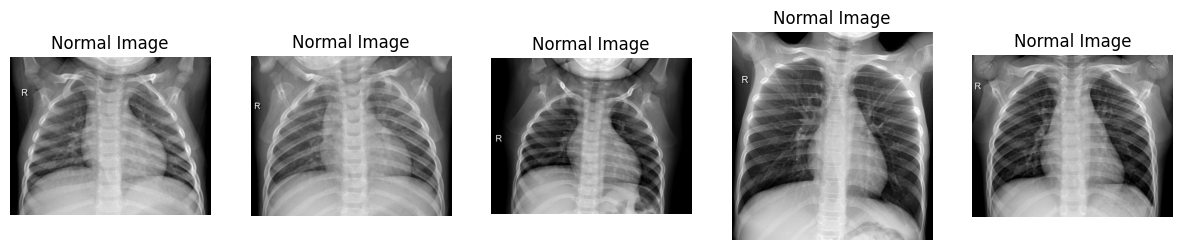

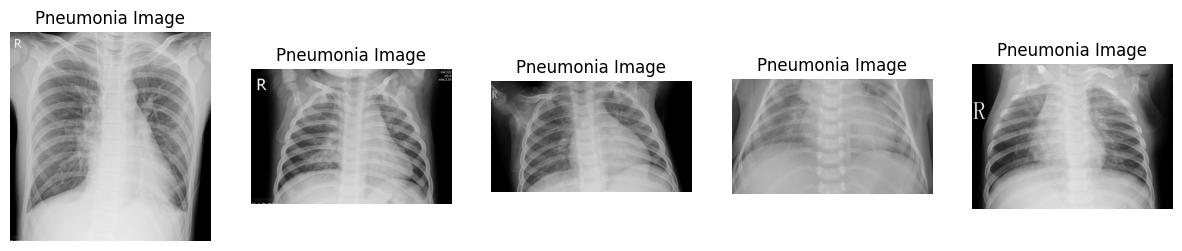

In [45]:

def load_random_images(directory, num_images=5):
    image_files = os.listdir(directory)
    random_files = random.sample(image_files, num_images)
    images = []
    for file in random_files:
        image_path = os.path.join(directory, file)
        image = cv2.imread(image_path)
        images.append(image)
    return images

def display_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, image, title in zip(axes, images, titles):
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# Directory paths for normal and pneumonia images
normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'
pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'

# Loading random normal and pneumonia images
random_normal_images = load_random_images(normal_dir)
random_pneumonia_images = load_random_images(pneumonia_dir)

# Displaying random normal and pneumonia images
display_images(random_normal_images, ['Normal Image'] * len(random_normal_images))
display_images(random_pneumonia_images, ['Pneumonia Image'] * len(random_pneumonia_images))

# Image after applying GaussianBlur filter

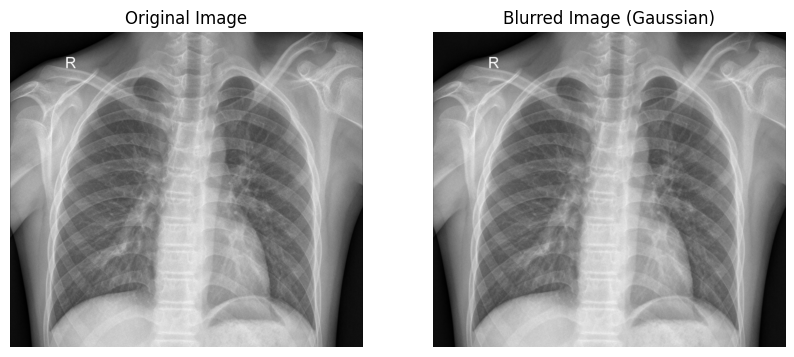

In [41]:

image = cv2.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg')

# Converting image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Applying Gaussian blur to the grayscale image
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)  

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image (Gaussian)')
plt.axis('off')

plt.show()

# Preprocessing

## Image Preprocessing Function Explanation

This function performs preprocessing steps on an input image to prepare it for further analysis or training.

### Parameters:
- `image`: Input image to be preprocessed.

### Steps:
1. Resize the image to a standard size of 224x224 pixels using `cv2.resize()` function.
2. Split the resized image into its individual color channels: Blue (b), Green (g), and Red (r) using `cv2.split()` function.
3. Apply Gaussian blur to each color channel separately:
   - Gaussian blur is applied using `cv2.GaussianBlur()` with a kernel size of (5, 5) and a sigma value of 3.
   - This step helps in reducing noise and smoothing out the image.
4. Merge the blurred color channels back together using `cv2.merge()` function.
5. Normalize the pixel values of the blurred image between 0 and 1 by converting it to float32 and dividing by 255.0.

The preprocessing steps help in enhancing the quality of the image and making it suitable for use in machine learning models or computer vision tasks.


In [3]:

def preprocess_image(image):
    # Resizing to 224x224
    image = cv2.resize(image, (224, 224))
    
    # Spliting image into channels
    b, g, r = cv2.split(image)

    # Apply Gaussian blur to each channel separately
    b_blur = cv2.GaussianBlur(b, (5, 5), 3)
    g_blur = cv2.GaussianBlur(g, (5, 5), 3)
    r_blur = cv2.GaussianBlur(r, (5, 5), 3)

    # Merging the blurred channels back together
    blurred_image = cv2.merge([b_blur, g_blur, r_blur])
    
    # Normalizing between 0 and 1
    blurred_image = blurred_image.astype('float32') / 255.0
    
    return blurred_image

# Data Augmentation

In [4]:
def shuffle_data (X, y):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y

## Data Augmentation Function Explanation

This function applies data augmentation techniques to enhance the training data.

### Parameters:
- `X`: Features or input data.
- `y`: Labels or output data.
- `batch_size`: Batch size used during training.

### Steps:
1. Shuffle the input data using the `shuffle_data()` function.
2. Initialize an `ImageDataGenerator` object with various augmentation parameters:
   - `rotation_range`: Random rotation of the image by 20 degrees.
   - `width_shift_range`: Random horizontal shift of the image by 10% of the total width.
   - `height_shift_range`: Random vertical shift of the image by 10% of the total height.
   - `shear_range`: Random shearing transformations with a shear intensity of 0.2.
   - `zoom_range`: Random zooming of the image by 20%.
   - `horizontal_flip`: Random horizontal flipping of the image.
   - `vertical_flip`: No vertical flipping.
   - `validation_split`: Split ratio for validation data (20% in this case).
3. Generate augmented training data and validation data using `flow()` method of `ImageDataGenerator`:
   - `train_generator`: Generates augmented training data subset.
   - `validation_generator`: Generates augmented validation data subset.
4. Return the generated train and validation data generators (`train_generator` and `validation_generator`).

The data augmentation techniques help in increasing the diversity of the training data, which can improve the model's generalization and performance.


In [5]:
def apply_data_augmentation (X, y, batch_size):
    
    # performing random shuffle
    X, y = shuffle_data (X, y)

    datagen = ImageDataGenerator(
        rotation_range=20, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.2
    )
    
    # we have specified the training and validation subsets while augmenting
    train_generator = datagen.flow(X,y , batch_size=batch_size, subset='training')
    validation_generator = datagen.flow(X, y, batch_size=batch_size, subset='validation')
    
    return train_generator, validation_generator

In [7]:
def visualize_augmented_data (train_data):
    # Geting one batch of augmented samples from the generator to visualize
    augmented_samples, _ = next(train_data)

    # Plotting a few augmented samples
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_samples[i].astype('float64'))
        plt.axis('off')
    plt.show()

In [8]:
def load_images(dir_path):
    images = []
    for filename in os.listdir(dir_path):
        if filename.endswith('.jpeg'):  
            image_path = os.path.join(dir_path, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image = preprocess_image(image) # sending for preprocessing
            images.append(image)
            
    return np.array(images)

In [9]:
def load_data ():
    normal_images = np.concatenate((load_images('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'), load_images('/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL')),axis=0)
    pneumonia_images = load_images('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA')

    X = np.concatenate((normal_images, pneumonia_images), axis=0)
    y = np.concatenate((np.zeros(len(normal_images)), np.ones(len(pneumonia_images))))
    
    return X, y

## Evaluate Model Function

This function evaluates a machine learning model using a set of normal test images and pneumonia test images.

### Parameters:
- `model`: The trained machine learning model to be evaluated.
- `normal_test_images`: List of normal test images.
- `pneumonia_test_images`: List of pneumonia test images.

### Returns:
A dictionary containing the evaluation metrics and the confusion matrix.

### Evaluation Metrics:
- **Confusion Matrix**: Visual representation of true positives, true negatives, false positives, and false negatives.
- **Accuracy**: Ratio of correct predictions to total predictions.
- **Precision**: Ratio of true positives to the sum of true positives and false positives.
- **Recall**: Ratio of true positives to the sum of true positives and false negatives.
- **F1 Score**: Harmonic mean of precision and recall.
- **ROC AUC Score**: Area under the Receiver Operating Characteristic curve.
- **Intersection over Union (IoU)**: Jaccard similarity coefficient measuring the overlap between predicted and true labels.

### Example Usage:
```python
evaluation = evaluate_model(model, normal_test_images, pneumonia_test_images)
print(evaluation)


In [23]:
def evaluate_model(model, normal_test_images, pneumonia_test_images):
    # lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    predicted_probabilities = []

    # Evaluating model on normal test images
    for image in normal_test_images:
        image = np.expand_dims(image, axis=0) 
        pred = model.predict(image)
        true_labels.append(0)  # 0 represents normal
        predicted_labels.append(1 if pred > 0.5 else 0)  # Predict 1 for pneumonia if probability > 0.5
        predicted_probabilities.append(pred[0][0]) 

    # Evaluating model on pneumonia test images
    for image in pneumonia_test_images:
        image = np.expand_dims(image, axis=0)  
        pred = model.predict(image)
        true_labels.append(1)  # 1 represents pneumonia
        predicted_labels.append(1 if pred > 0.5 else 0)  # Predict 1 for pneumonia if probability > 0.5
        predicted_probabilities.append(pred[0][0])  

    # Calculating evaluation metrics
    cm = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)
    iou = jaccard_score(true_labels, predicted_labels)

    # Ploting confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Normal', 'Pneumonia']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Intersection over Union (IoU): {iou:.4f}')

    return {
        'Confusion Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'IoU': iou
    }


## Data Loading and Augmentation

### Loading Data:
- Load data using `load_data()` function, which returns features (X) and labels (y).
- Set batch size to 32.

### Data Augmentation:
- Apply data augmentation using `apply_data_augmentation()` function on the loaded data (X, y) with the specified batch size.
- This step generates augmented training and validation data for the model.

### Loading Test Images:
- Load normal and pneumonia test images using `load_images()` function from specified directories.
- Normal test images are from the 'NORMAL' directory, and pneumonia test images are from the 'PNEUMONIA' directory.

### Visualizing Augmented Data:
- Use the `visualize_augmented_data()` function to visualize the augmented training data (`train_data`).


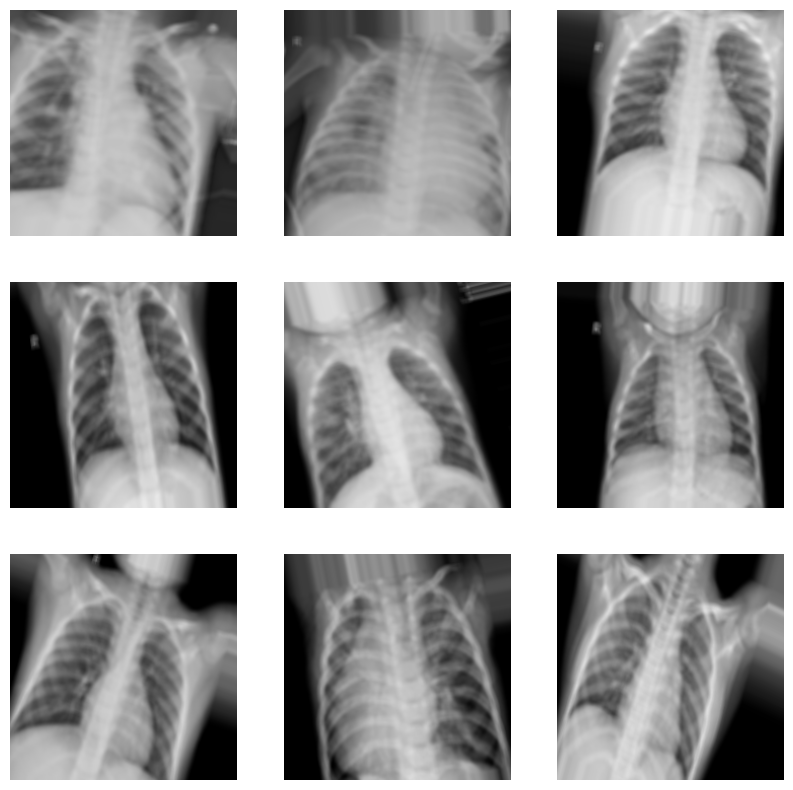

In [10]:
X, y = load_data()
batch_size = 32
# training and validation data
train_data , validation_data = apply_data_augmentation (X, y, batch_size = batch_size)

# testing data
normal_test_images = load_images('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL')
pneumonia_test_images = load_images('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA')

visualize_augmented_data(train_data)

In [36]:
print("Total data shape: " ,X.shape)
print("Total labes shape: ", y.shape)
print("Training data shape: ", train_data.n)
print("Validation data shape: ", validation_data.n)
print("Normal test Images: ", normal_test_images.shape)
print("Pnemunia test Images: ", pneumonia_test_images.shape)

Total data shape:  (6565, 224, 224, 3)
Total labes shape:  (6565,)
Training data shape:  5252
Validation data shape:  1313
Normal test Images:  (234, 224, 224, 3)
Pnemunia test Images:  (390, 224, 224, 3)


> ****We will be using multiple models to see the results on different models and see which model performes best****

# Plot Model History

In [16]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

### InceptionResNetV2 Model Creation

The `create_inception_resnetv3_model` function is used to construct a customized deep learning model based on the InceptionResNetV2 architecture, which is pre-trained on the ImageNet dataset. This function is typically employed for transfer learning scenarios, where the pre-trained InceptionResNetV2 model is fine-tuned on a specific task or dataset.

#### Steps:

1. **Base Model Initialization:**
   - Initializes the InceptionResNetV2 base model with pre-trained weights from ImageNet.
   - `weights='imagenet'` ensures the model is loaded with the ImageNet weights.
   - `include_top=False` excludes the top classification layers of the model for customization.

2. **Fine-tuning Layers:**
   - Iterates through the layers of the base model, excluding the last 4 layers (`layers[:-4]`).
   - Sets these layers as trainable, enabling fine-tuning during model training.

3. **Sequential Model Construction:**
   - Initializes a new Sequential model to build the custom architecture.
   - Adds the pre-trained InceptionResNetV2 base model to the Sequential model.
   - Incorporates a Global Average Pooling 2D layer to reduce spatial dimensions and extract features.
   - Appends a Dense layer with 512 units and ReLU activation for feature transformation.
   - Includes a Dropout layer with a dropout rate of 0.5 to mitigate overfitting.
   - Adds another Dense layer with 256 units and ReLU activation for further feature processing.
   - Includes a Dropout layer with a dropout rate of 0.3 for regularization.
   - Adds a final Dense layer with 1 unit and Sigmoid activation for binary classification tasks.

4. **Return Value:**
   - Returns the compiled model ready for training and evaluation.

This model architecture is suitable for fine-tuning on specific image classification tasks, offering flexibility in adjusting the model's layers while leveraging knowledge from the ImageNet dataset.


In [18]:
def create_inception_resnetv3_model():
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-4]:  # Fine-tuning the last few layers
        layer.trainable = True

    model = Sequential()

    model.add(base_model)
    model.add(GlobalAveragePooling2D())  # Global Average Pooling instead of Flatten
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [19]:
inception_resnet_v2 = create_inception_resnetv3_model()
inception_resnet_v2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
inception_resnet_v2.summary();

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 54,276,192 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [20]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)) 
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

## Callbacks for Model Training

These callbacks are commonly used during model training to improve training efficiency, prevent overfitting, and adjust learning rates.

### `EarlyStopping`
- **Monitor:** Validation loss
- **Patience:** Number of epochs with no improvement before stopping (5 in this case)
- **Restore Best Weights:** Restores the model weights from the epoch with the best validation loss

### `LearningRateScheduler`
- **Lambda Function:** Adjusts learning rate based on the epoch number
- **Initial Learning Rate:** 1e-3 (0.001)
- **Decay Rate:** 0.9, reducing learning rate by 10% after each epoch

### `ReduceLROnPlateau`
- **Monitor:** Validation loss
- **Factor:** Factor by which the learning rate will be reduced (0.2 means LR will be multiplied by 0.2)
- **Patience:** Number of epochs with no improvement before reducing LR
- **Min LR:** Minimum learning rate allowed (0.001 in this case)

### Usage Example:
```python
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)) 
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping, lr_scheduler, reduce_lr])


# Training InceptionResNetv2

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714304522.176127      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


165/165 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.8635 - loss: 0.3374 - val_accuracy: 0.8660 - val_loss: 0.6983 - learning_rate: 0.0010
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 69s 405ms/step - accuracy: 0.9502 - loss: 0.1423 - val_accuracy: 0.8842 - val_loss: 0.3827 - learning_rate: 9.0000e-04
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 69s 402ms/step - accuracy: 0.9495 - loss: 0.1314 - val_accuracy: 0.8949 - val_loss: 3.7408 - learning_rate: 8.1000e-04
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 68s 400ms/step - accuracy: 0.9535 - loss: 0.1352 - val_accuracy: 0.6839 - val_loss: 1.3862 - learning_rate: 7.2900e-04
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 69s 401ms/step - accuracy: 0.9560 - loss: 0.1112 - val_accuracy: 0.9756 - val_loss: 0.0611 - learning_rate: 6.5610e-04
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 68s 401ms/step - accuracy: 0.9737 - loss: 0.0744 - val_accuracy: 0.9482 - val_loss: 0.1291 - learning_rate: 5.9049e-04
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 68s 400ms/step - accura

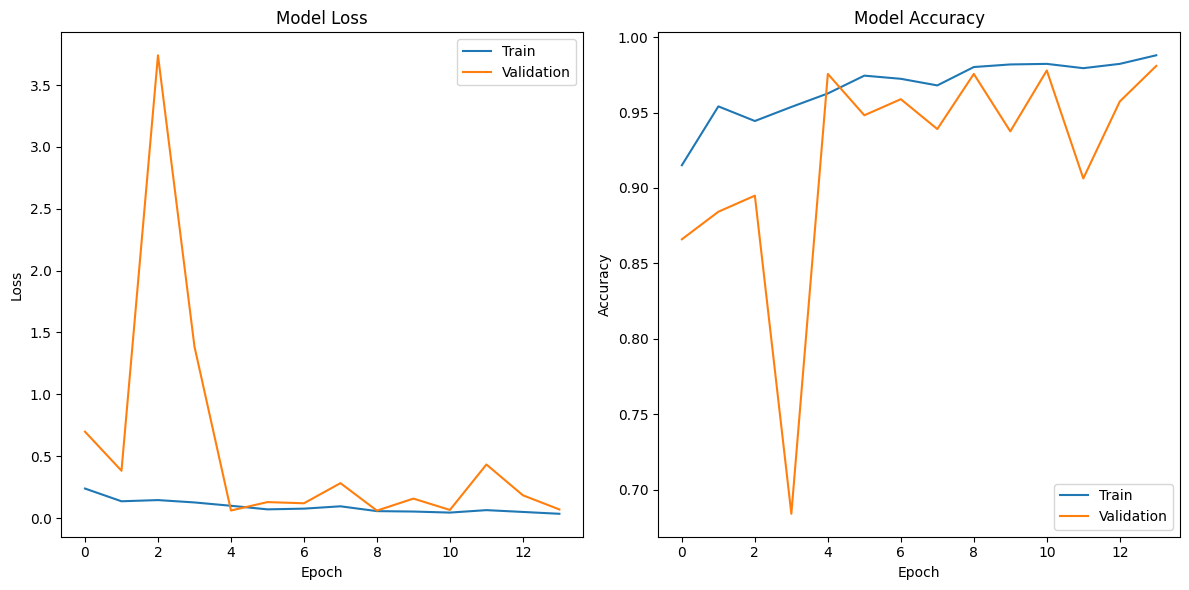

In [21]:
device = tf.config.list_physical_devices('GPU')
if device:
    print('GPU:', device[0])
    
    history = inception_resnet_v2.fit(train_data, epochs=50, batch_size=32, validation_data=validation_data, callbacks=[early_stopping, lr_scheduler, reduce_lr])
    plot_history(history)
    
else:
    print("No GPU Found")

# Evaluation

42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.9748 - loss: 0.0683
Loss: 0.07996221631765366  Accuracy:  0.9710586667060852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45m

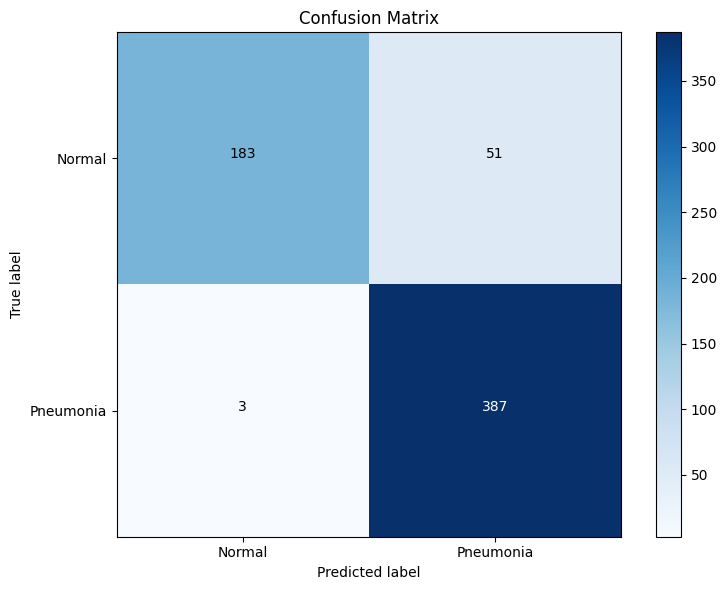

Accuracy: 0.9135
Precision: 0.8836
Recall: 0.9923
F1 Score: 0.9348
ROC AUC Score: 0.9785
Intersection over Union (IoU): 0.8776


{'Confusion Matrix': array([[183,  51],
        [  3, 387]]),
 'Accuracy': 0.9134615384615384,
 'Precision': 0.8835616438356164,
 'Recall': 0.9923076923076923,
 'F1 Score': 0.9347826086956521,
 'ROC AUC': 0.9785064650449266,
 'IoU': 0.8775510204081632}

In [24]:
evaluation = inception_resnet_v2.evaluate(validation_data)
print("Loss:", evaluation[0], " Accuracy: ", evaluation[1])

evaluate_model(inception_resnet_v2, normal_test_images,pneumonia_test_images)

# Xception

### Xception Model Creation

The `create_xception_model` function is used to build a custom deep learning model based on the Xception architecture, which is pre-trained on the ImageNet dataset. This function is typically used for transfer learning, where you fine-tune the pre-trained Xception model on a specific task or dataset.

#### Steps:

1. **Base Model Initialization:**
   - Initializes the Xception base model with pre-trained weights from ImageNet.
   - `weights='imagenet'` ensures that the model is loaded with the ImageNet weights.
   - `include_top=False` excludes the top classification layers of the model, allowing customization.

2. **Fine-tuning Layers:**
   - Loops through the layers of the base model, excluding the last 4 layers (`layers[:-4]`).
   - Sets these layers as trainable, enabling fine-tuning during model training.

3. **Sequential Model Construction:**
   - Initializes a new Sequential model to build the custom architecture.
   - Adds the pre-trained Xception base model to the Sequential model.
   - Adds a Global Average Pooling 2D layer to reduce spatial dimensions and extract features.
   - Adds a Dense layer with 512 units and ReLU activation for feature transformation.
   - Includes a Dropout layer with a dropout rate of 0.5 to prevent overfitting.
   - Adds another Dense layer with 256 units and ReLU activation for further feature processing.
   - Includes a Dropout layer with a dropout rate of 0.3 for regularization.
   - Adds a final Dense layer with 1 unit and Sigmoid activation for binary classification tasks.

4. **Return Value:**
   - Returns the compiled model ready for training and evaluation.

This model architecture is suitable for fine-tuning on specific image classification tasks, providing flexibility in adjusting the model's layers while leveraging the knowledge learned from the ImageNet dataset.


In [26]:
def create_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-4]:  # Fine-tuning the last few layers
        layer.trainable = True

    model = Sequential()

    model.add(base_model)
    model.add(GlobalAveragePooling2D())  # Global Average Pooling instead of Flatten
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [27]:
xception = create_xception_model()
xception.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
xception.summary();

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 159s 558ms/step - accuracy: 0.8819 - loss: 0.2880 - val_accuracy: 0.9528 - val_loss: 0.1872 - learning_rate: 0.0010
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 66s 387ms/step - accuracy: 0.9575 - loss: 0.1229 - val_accuracy: 0.9391 - val_loss: 0.1685 - learning_rate: 9.0000e-04
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 66s 384ms/step - accuracy: 0.9636 - loss: 0.0950 - val_accuracy: 0.9749 - val_loss: 0.0805 - learning_rate: 8.1000e-04
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 65s 382ms/step - accuracy: 0.9687 - loss: 0.0918 - val_accuracy: 0.9749 - val_loss: 0.0759 - learning_rate: 7.2900e-04
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 65s 382ms/step - accuracy: 0.9784 - loss: 0.0644 - val_accuracy: 0.8911 - val_loss: 0.3718 - learning_rate: 6.5610e-04


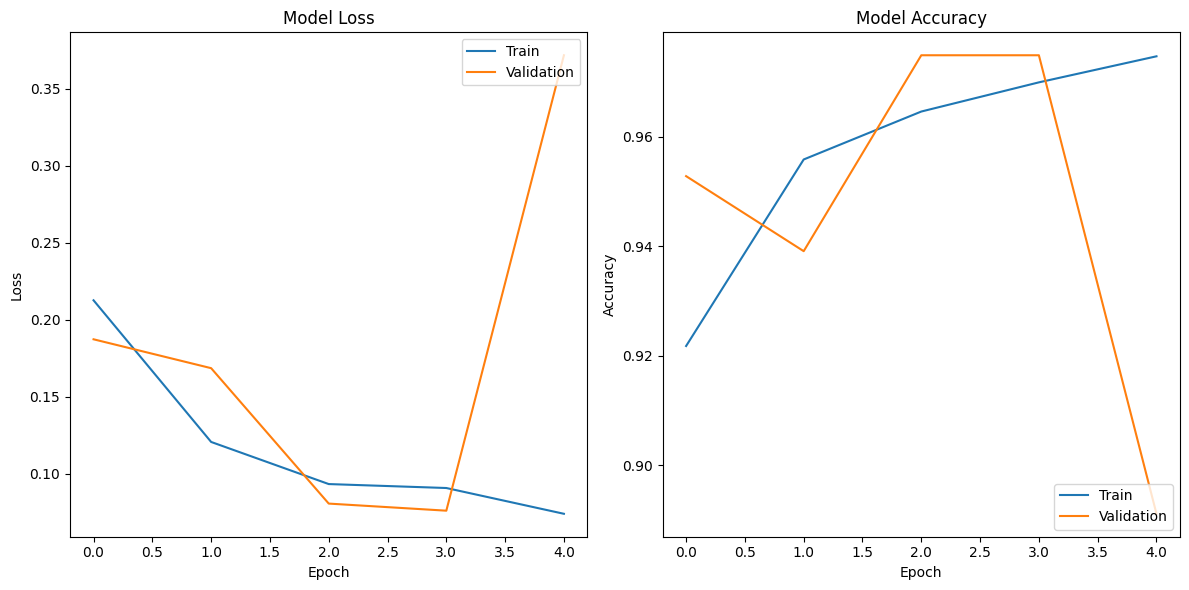

In [28]:
device = tf.config.list_physical_devices('GPU')
if device:
    print('GPU:', device[0])
    
    history = xception.fit(train_data, epochs=50, batch_size=32, validation_data=validation_data, callbacks=[early_stopping, lr_scheduler, reduce_lr])
    plot_history(history)
    
else:
    print("No GPU Found")

42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step - accuracy: 0.9492 - loss: 0.2015
Loss: 0.1764562577009201  Accuracy:  0.9550647139549255
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/s

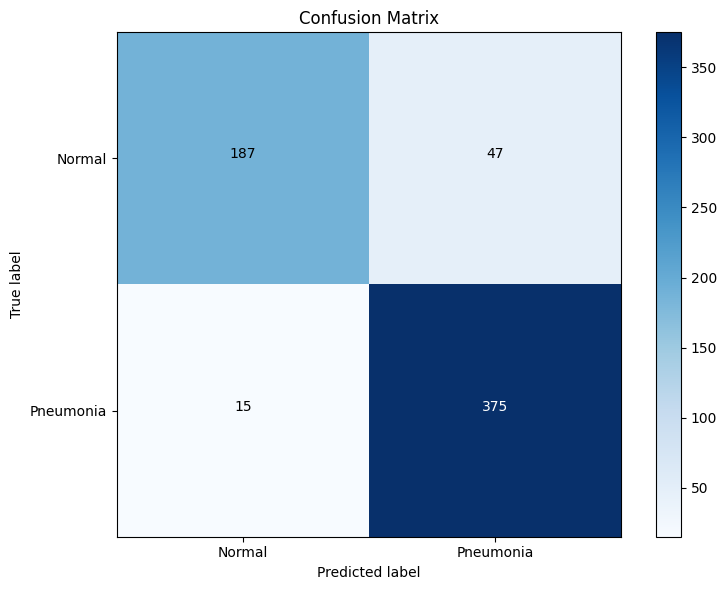

Accuracy: 0.9006
Precision: 0.8886
Recall: 0.9615
F1 Score: 0.9236
ROC AUC Score: 0.9472
Intersection over Union (IoU): 0.8581


{'Confusion Matrix': array([[187,  47],
        [ 15, 375]]),
 'Accuracy': 0.9006410256410257,
 'Precision': 0.8886255924170616,
 'Recall': 0.9615384615384616,
 'F1 Score': 0.9236453201970444,
 'ROC AUC': 0.9472222222222222,
 'IoU': 0.8581235697940504}

In [29]:
evaluation = xception.evaluate(validation_data)
print("Loss:", evaluation[0], " Accuracy: ", evaluation[1])

evaluate_model(xception, normal_test_images,pneumonia_test_images)

# ResNet101

### ResNet101 Model Creation

The `create_resnet101_model` function is used to build a custom deep learning model based on the ResNet101 architecture, which is pre-trained on the ImageNet dataset. This function is typically employed for transfer learning scenarios, where the pre-trained ResNet101 model is fine-tuned on a specific task or dataset.

#### Steps:

1. **Base Model Initialization:**
   - Initializes the ResNet101 base model with pre-trained weights from ImageNet.
   - `weights='imagenet'` ensures the model is loaded with the ImageNet weights.
   - `include_top=False` excludes the top classification layers of the model for customization.

2. **Fine-tuning Layers:**
   - Iterates through the layers of the base model, excluding the last 4 layers (`layers[:-4]`).
   - Sets these layers as trainable, enabling fine-tuning during model training.

3. **Sequential Model Construction:**
   - Initializes a new Sequential model to build the custom architecture.
   - Adds the pre-trained ResNet101 base model to the Sequential model.
   - Incorporates a Global Average Pooling 2D layer to reduce spatial dimensions and extract features.
   - Appends a Dense layer with 512 units and ReLU activation for feature transformation.
   - Includes a Dropout layer with a dropout rate of 0.5 to mitigate overfitting.
   - Adds another Dense layer with 256 units and ReLU activation for further feature processing.
   - Includes a Dropout layer with a dropout rate of 0.3 for regularization.
   - Adds a final Dense layer with 1 unit and Sigmoid activation for binary classification tasks.

4. **Return Value:**
   - Returns the compiled model ready for training and evaluation.

This model architecture is suitable for fine-tuning on specific image classification tasks, offering flexibility in adjusting the model's layers while leveraging knowledge from the ImageNet dataset.


In [30]:
def create_resnet101_model():
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-4]:  # Fine-tuning the last few layers
        layer.trainable = True

    model = Sequential()

    model.add(base_model)
    model.add(GlobalAveragePooling2D())  # Global Average Pooling instead of Flatten
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [31]:

resnet101 = create_xception_model()
resnet101.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
resnet101.summary();

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 66s 386ms/step - accuracy: 0.9496 - loss: 0.1469 - val_accuracy: 0.8949 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 65s 380ms/step - accuracy: 0.9664 - loss: 0.0919 - val_accuracy: 0.8644 - val_loss: 0.9975 - learning_rate: 9.0000e-04
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 65s 382ms/step - accuracy: 0.9699 - loss: 0.0848 - val_accuracy: 0.9444 - val_loss: 0.2205 - learning_rate: 8.1000e-04
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - accuracy: 0.9744 - loss: 0.0717 - val_accuracy: 0.6832 - val_loss: 1.1983 - learning_rate: 7.2900e-04
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 66s 386ms/step - accuracy: 0.9787 - loss: 0.0722 - val_accuracy: 0.9764 - val_loss: 0.0760 - learning_rate: 6.5610e-04


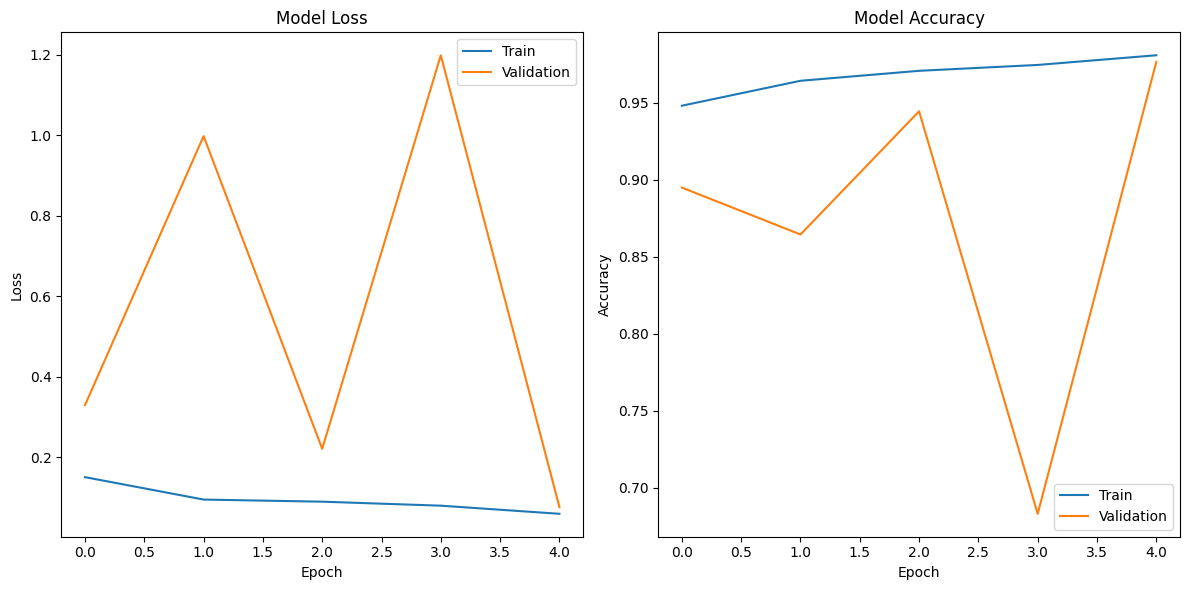

In [46]:
device = tf.config.list_physical_devices('GPU')
if device:
    print('GPU:', device[0])
    
    history = resnet101.fit(train_data, epochs=50, batch_size=32, validation_data=validation_data, callbacks=[early_stopping, lr_scheduler, reduce_lr])
    plot_history(history)
    
else:
    print("No GPU Found")

42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - accuracy: 0.8798 - loss: 0.3133
Loss: 0.298224538564682  Accuracy:  0.8948971629142761
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/

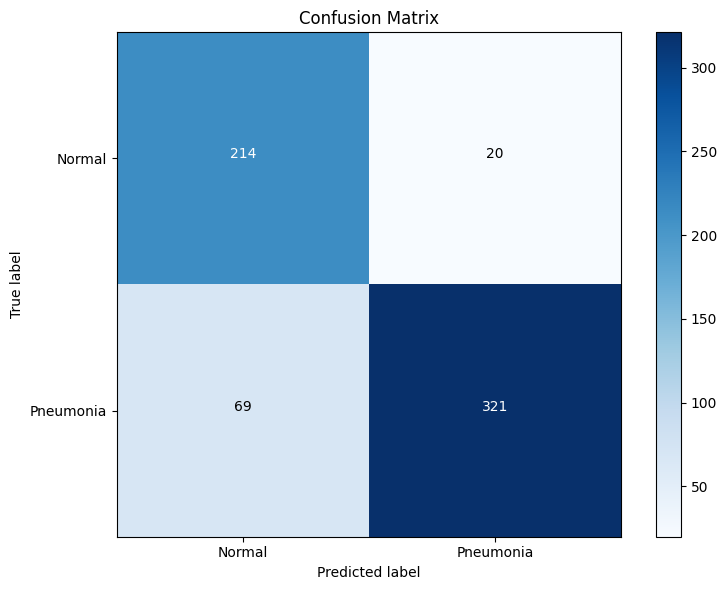

Accuracy: 0.8574
Precision: 0.9413
Recall: 0.8231
F1 Score: 0.8782
ROC AUC Score: 0.9304
Intersection over Union (IoU): 0.7829


{'Confusion Matrix': array([[214,  20],
        [ 69, 321]]),
 'Accuracy': 0.8573717948717948,
 'Precision': 0.9413489736070382,
 'Recall': 0.823076923076923,
 'F1 Score': 0.8782489740082079,
 'ROC AUC': 0.9303747534516766,
 'IoU': 0.7829268292682927}

In [47]:
evaluation = resnet101.evaluate(validation_data)
print("Loss:", evaluation[0], " Accuracy: ", evaluation[1])

evaluate_model(resnet101, normal_test_images,pneumonia_test_images)